# 라이브러리 불러오기

In [81]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib # urllib 패키지는 웹에서 데이터를 다운로드 받을 때 사용합니다.

from matplotlib import pyplot as plt
import tensorflow as tf

# 이미지 불러오기

In [82]:
import os
img_person_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/tom_hardy.png'  # 사림 이미지 경로 
img_cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat1.jpg'  # 고양이 이미지 경로 
img_bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpg'  # 배경 이미지 경로 


img_person_orig = cv2.imread(img_person_path) 
img_cat_orig = cv2.imread(img_cat_path) 
img_bg_orig = cv2.imread(img_bg_path) 



print (img_person_orig.shape) 
print (img_cat_orig.shape) 
print (img_bg_orig.shape) 

(472, 700, 3)
(693, 720, 3)
(868, 1234, 3)


# 사이즈 맞추기   
472, 700로 통일해준다.

In [83]:
img_cat_orig = cv2.resize(img_cat_orig, dsize=(700,472), interpolation=cv2.INTER_AREA)
img_bg_orig = cv2.resize(img_bg_orig, dsize=(700,472), interpolation=cv2.INTER_AREA)

print (img_person_orig.shape) 
print (img_cat_orig.shape) 
print (img_bg_orig.shape) 

(472, 700, 3)
(472, 700, 3)
(472, 700, 3)


# DeepLab 모델을 가져오기
구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만든다.

In [84]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

# 학습된 가중치 불러오기
사전에 학습된 가중치(pretrained weight)를 불러 옵니다.

In [85]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')
# 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 받고 DeepLabModel 을 초기화합니다.
# 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.


temp directory: /home/aiffel-dj60/aiffel/human_segmentation/models
model loaded successfully!


# 이미지를 네트워크에 입력하기

15=> person   
8 => cat     
0 => background 

In [128]:
img_person_resized, seg_person_map = MODEL.run(img_person_orig)
print (img_person_orig.shape, img_person_resized.shape, seg_person_map.max())
#이미지 (472, 700, 3) -> (345, 513, 3)

img_cat_resized, seg_cat_map = MODEL.run(img_cat_orig)
print (img_cat_orig.shape, img_cat_resized.shape, seg_cat_map.max())
#이미지 (693, 720, 3) -> (493, 513, 3) 

img_bg_resized, seg_bg_map = MODEL.run(img_bh_orig)
print (img_bg_orig.shape, img_bg_resized.shape, seg_bg_map.max())
#이미지 (868, 1234, 3) -> (360, 513)


(472, 700, 3) (345, 513, 3) 15
(472, 700, 3) (345, 513, 3) 8
(472, 700, 3) (360, 513, 3) 0


 # 라벨 종류
 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 제공하는 라벨 종류는 아래와 같다.

In [87]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

```
지금까지 우리가 생성한 변수
img_person_orig
img_person_resized
seg_person_map 

img_cat_orig
img_cat_resized.shape
seg_cat_map

img_bg_orig.shape
img_bg_resized
seg_bg_map

```

# 사람에 대한 세그멘테이션 확인하기

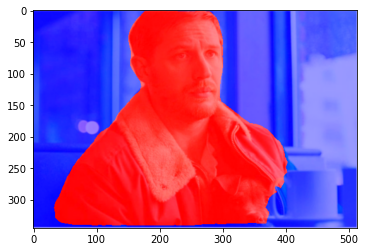

In [88]:
img_person_show = img_person_resized.copy()
seg_person_map = np.where(seg_person_map == 15, 15, 0) # 예측 중 사람만 추출
img_person_mask = seg_person_map * (255/seg_person_map.max()) # 255 normalization
img_person_mask = img_person_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_person_mask, cv2.COLORMAP_JET)
img_person_show = cv2.addWeighted(img_person_show, 0.6, color_mask, 2.35, 0.0)

plt.imshow(cv2.cvtColor(img_person_show, cv2.COLOR_BGR2RGB))
plt.show()

# 고양이에 대한 세그멘테이션 확인하기

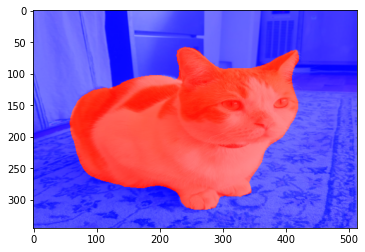

In [89]:
img_cat_show = img_cat_resized.copy()
seg_cat_map = np.where(seg_cat_map == 8, 8, 0) # 예측 중 사람만 추출
img_cat_mask = seg_cat_map * (255/seg_cat_map.max()) # 255 normalization
img_cat_mask = img_cat_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_cat_mask, cv2.COLORMAP_JET)
img_cat_show = cv2.addWeighted(img_cat_show, 0.6, color_mask, 2.35, 0.0)

plt.imshow(cv2.cvtColor(img_cat_show, cv2.COLOR_BGR2RGB))
plt.show()

# 세그멘테이션 결과를 원래 크기로 복원하기

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했습니다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.

세그멘테이션 결과(mask)를 원래 크기로 복원하기

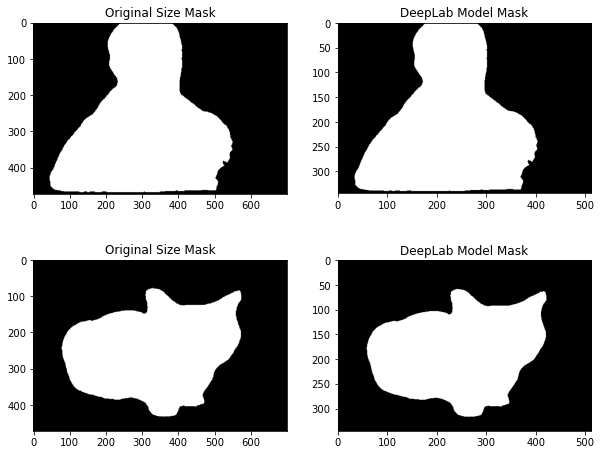

In [112]:
img_person_mask_up = cv2.resize(img_person_mask, img_person_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_person_mask_up = cv2.threshold(img_person_mask_up, 128, 255, cv2.THRESH_BINARY)

img_cat_mask_up = cv2.resize(img_cat_mask, img_cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_cat_mask_up = cv2.threshold(img_cat_mask_up, 128, 255, cv2.THRESH_BINARY)


plt.figure(figsize=(10, 8))
ax = plt.subplot(2,2,1)
plt.imshow(img_person_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(2,2,2)
plt.imshow(img_person_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')


ax = plt.subplot(2,2,3)
plt.imshow(img_cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(2,2,4)
plt.imshow(img_cat_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')


plt.show()

# 배경 뽑기

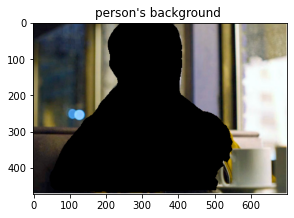

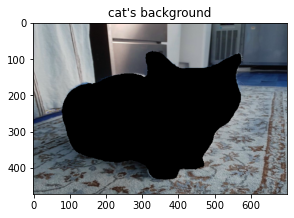

In [115]:
img_person_mask_color = cv2.cvtColor(img_person_mask_up, cv2.COLOR_GRAY2BGR)
img_person_bg_mask = cv2.bitwise_not(img_person_mask_color)
img_person_bg = cv2.bitwise_and(img_person_orig, img_person_bg_mask)



img_cat_mask_color = cv2.cvtColor(img_cat_mask_up, cv2.COLOR_GRAY2BGR)
img_cat_bg_mask = cv2.bitwise_not(img_cat_mask_color)
img_cat_bg = cv2.bitwise_and(img_cat_orig, img_cat_bg_mask)


plt.figure(figsize=(10, 8))
ax = plt.subplot(1,2,1)
plt.imshow(img_person_bg,cmap=plt.cm.binary_r)
ax.set_title('person\'s background ')

plt.figure(figsize=(10, 8))
ax = plt.subplot(1,2,2)
plt.imshow(img_cat_bg,cmap=plt.cm.binary_r)
ax.set_title('cat\'s background')

plt.show()

# 배경 블러 적용하기


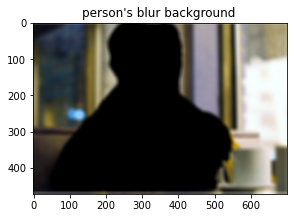

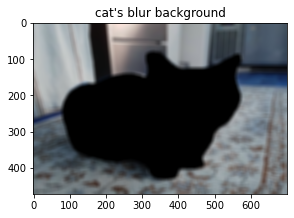

In [122]:
### 블러(blur)하면 배경이 흐리게 처리된 영상을 얻을 수 있습니다.

img_person_bg_blur = cv2.blur(img_person_bg, (13,13))
#plt.imshow(cv2.cvtColor(img_person_bg_blur, cv2.COLOR_BGR2RGB))


img_cat_bg_blur = cv2.blur(img_cat_bg, (13,13))
#plt.imshow(cv2.cvtColor(img_cat_bg_blur, cv2.COLOR_BGR2RGB))


plt.figure(figsize=(10, 8))
ax = plt.subplot(1,2,1)
plt.imshow(img_person_bg_blur)
ax.set_title('person\'s blur background ')

plt.figure(figsize=(10, 8))
ax = plt.subplot(1,2,2)
plt.imshow(img_cat_bg_blur)
ax.set_title('cat\'s blur background')


plt.show()

# 블러된 배경과 합치기

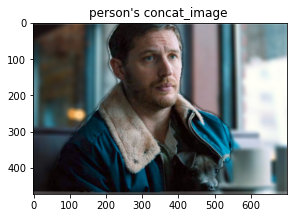

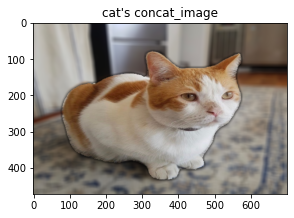

In [129]:
#블라된 배경과 사람그림 합치기
img_person_concat = np.where(img_person_mask_color==255, img_person_orig, img_person_bg_blur)
img_person_concat=cv2.cvtColor(img_person_concat, cv2.COLOR_BGR2RGB)


#블라된 배경과 고양이그림 합치기
img_cat_concat = np.where(img_cat_mask_color==255, img_cat_orig, img_cat_bg_blur)
img_cat_concat=cv2.cvtColor(img_cat_concat, cv2.COLOR_BGR2RGB)



plt.figure(figsize=(10, 8))
ax = plt.subplot(1,2,1)
plt.imshow(img_person_concat)
ax.set_title('person\'s concat_image ')

plt.figure(figsize=(10, 8))
ax = plt.subplot(1,2,2)
plt.imshow(img_cat_concat)
ax.set_title('cat\'s concat_image')


plt.show()

# 크로마키 적용하기

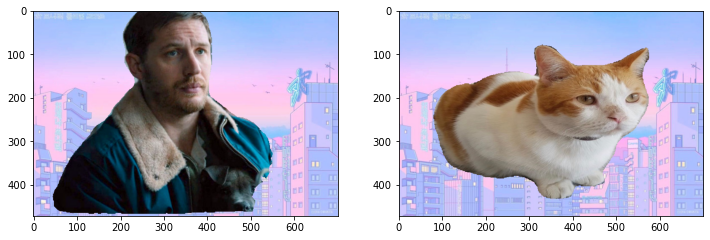

In [130]:


#누에따기된 사람과 배경 사진 합치기
img_person_concat1 = np.where(img_person_mask_color==255, img_person_orig, img_bg_orig)
#plt.imshow(cv2.cvtColor(img__person_concat1, cv2.COLOR_BGR2RGB))
img_person_concat1 = cv2.cvtColor(img__person_concat1, cv2.COLOR_BGR2RGB)

                            
#누에따기된 고양이와 배경 사진 합치기
img_cat_concat1 = np.where(img_cat_mask_color==255, img_cat_orig, img_bg_orig)
#plt.imshow(cv2.cvtColor(img_cat_concat1, cv2.COLOR_BGR2RGB))
img_cat_concat1 = cv2.cvtColor(img_cat_concat1, cv2.COLOR_BGR2RGB)

                                  
                                  
plt.figure(figsize=(12, 10))                                  
ax = plt.subplot(1,2,1)
plt.imshow(img_person_concat1)
ax = plt.subplot(1,2,2)
plt.imshow(img_cat_concat1)
                                  
plt.show()
                                  



평가문항
1. 인물모드 사진을 성공적으로 제작하였는가?   
아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.


2. 제작한 인물모드 사진들에서 나타나는 문제점을 무엇인가?    
인물사진에서 하단 오른족 유리컵이 놓여져 인물사진이 가려졌는데 그부분을 정확히 sementation하지 못했다.


3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
그림과 같이 인물사진에 유리컵같은 사물이 존재할경우 위 그림처럼 부자연스럽게 나올수 있다. 그렇다면 보정기술로 자연스럽게 그부분을 그려주는 기술을 찾으면 될것깉다. 
